In [1]:
%%bash
pip install timm onnx onnxruntime -q

In [2]:
import os
import sys
import cv2
import json
import onnx
import timm
import torch
import random as r
import numpy as np
import pandas as pd
import onnxruntime as ort
import matplotlib.pyplot as plt

from typing import Union
from torchvision import models
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("onnx"): os.makedirs("onnx")
    
ort.set_default_logger_severity(3)

In [3]:
labels: dict = json.load(open("/kaggle/input/iic-dataframe/labels.json", "r"))
    
    
def breaker() -> None:
    print("\n" + 50*"*" + "\n")


def get_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    return cv2.resize(src=image, dsize=(150, 150), interpolation=cv2.INTER_AREA)


def show_image(
    image: np.ndarray, 
    cmap: str="gnuplot2", 
    title: Union[str, None]=None
) -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.model = timm.create_model(model_name="efficientnet_b4", pretrained=False)
        self.model.classifier = torch.nn.Linear(in_features=self.model.classifier.in_features, out_features=6)

    def forward(self, x):
        return self.model(x)

    
class CFG(object):  
    def __init__(
        self, 
        in_channels: int=3, 
        size: int=256, 
        opset_version: int=9, 
        path: str=None
    ):
        self.in_channels = in_channels
        self.size = size
        self.dummy = torch.randn(1, self.in_channels, self.size, self.size)
        self.opset_version = opset_version
        self.path = path

In [5]:
for v in ["a", "l"]:
    cfg = CFG(
        in_channels=3, 
        size=150, 
        opset_version=15, 
        path=f"/kaggle/input/iic-en4-a150-e10-f1/saves/b{v}e_state_fold_1.pt"
    )

    model = Model()
    model.load_state_dict(torch.load(cfg.path, map_location=torch.device("cpu"))["model_state_dict"])
    model.eval()

    clear_output()

    torch.onnx.export(
        model=model, 
        args=cfg.dummy, 
        f=f"onnx/b{v}e_model_f1.onnx", 
        input_names=["input"], 
        output_names=["output"], 
        opset_version=cfg.opset_version,
        export_params=True,
        training=torch.onnx.TrainingMode.EVAL,
        operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK,
        dynamic_axes={
          "input"  : {0 : "batch_size"},
          "output" : {0 : "batch_size"},
        }
    )

In [6]:
class OnnxModel(object):
    def __init__(self, path: str) -> None:
        self.size: int = 150
        
        self.mean: list = [0.43071, 0.45766, 0.45409]
        self.std: list  = [0.23567, 0.23459, 0.24302]
        
        self.path: str = path
    
        model = onnx.load(self.path)
        onnx.checker.check_model(model)
        self.ort_session = ort.InferenceSession(self.path)
        
    def infer(self, image: np.ndarray, labels: dict) -> np.ndarray:
        image = image / 255
        image = cv2.resize(src=image, dsize=(self.size, self.size), interpolation=cv2.INTER_AREA).transpose(2, 0, 1)
        for i in range(image.shape[0]): image[i, :, :] = (image[i, :, :] - self.mean[i]) / self.std[i]
        image = np.expand_dims(image, axis=0)
        inputs = {self.ort_session.get_inputs()[0].name: image.astype("float32")}
        result = self.ort_session.run(None, inputs)
        odds = np.exp(np.max(result))
        return labels[str(np.argmax(result))].title(), odds / (1 + odds)


**************************************************

BAE_MODEL_F1.ONNX



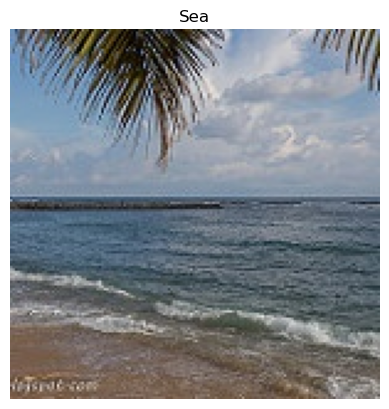

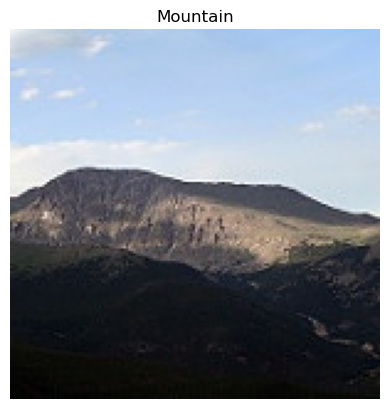

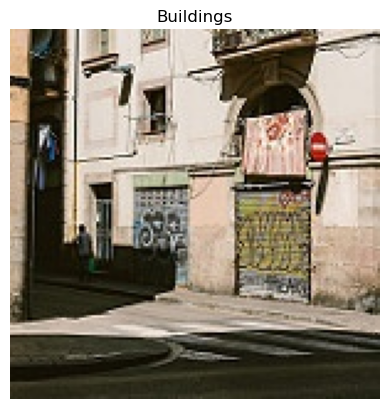

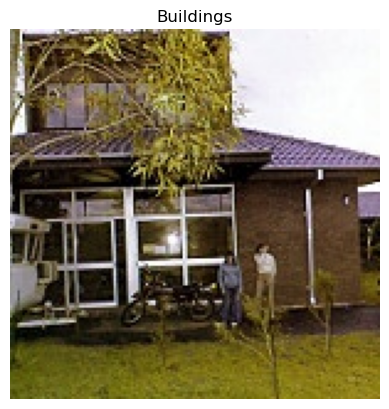

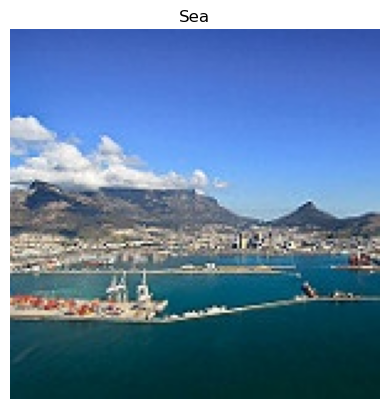

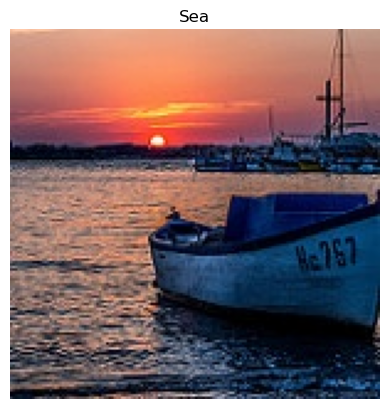

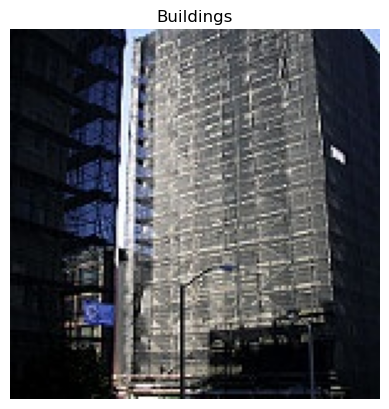

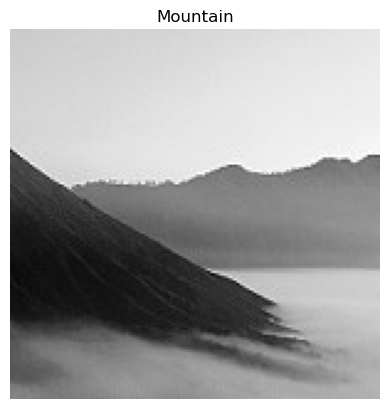

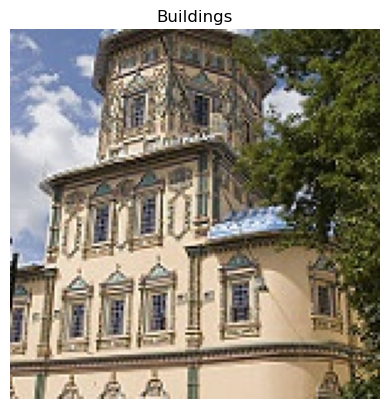


**************************************************

BLE_MODEL_F1.ONNX



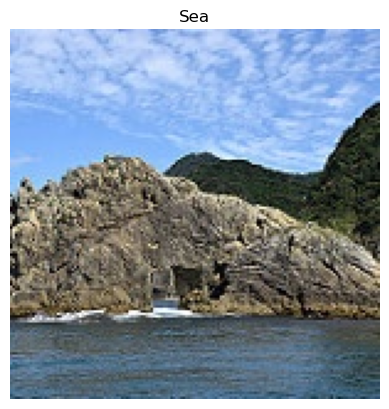

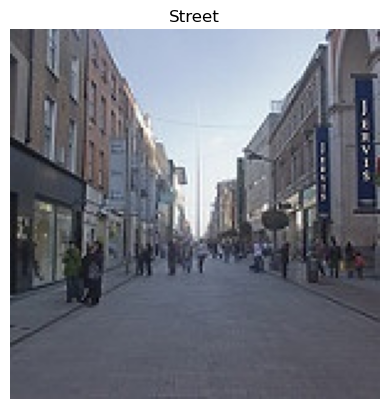

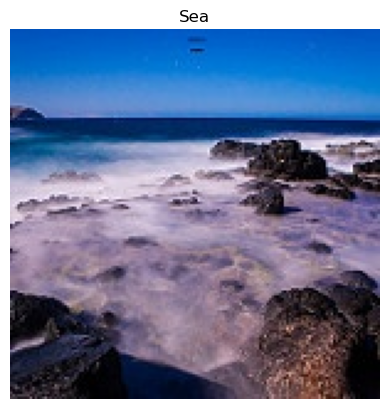

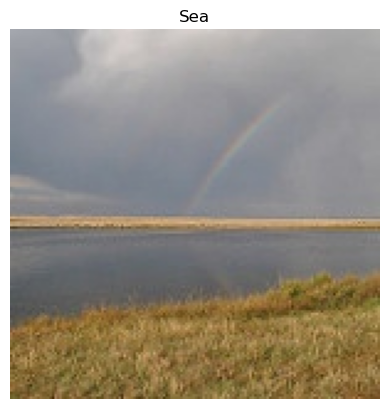

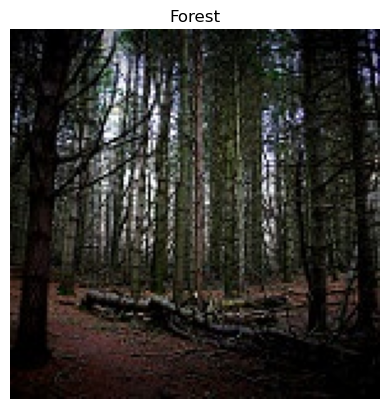

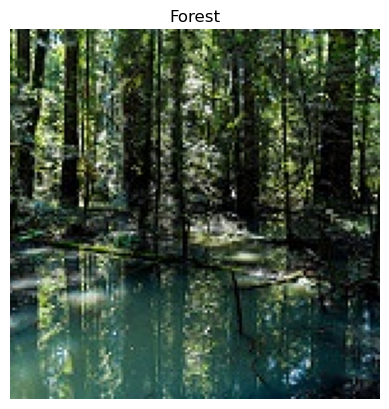

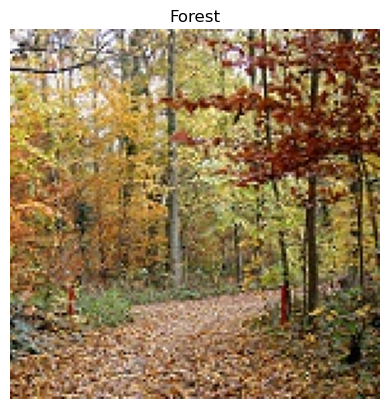

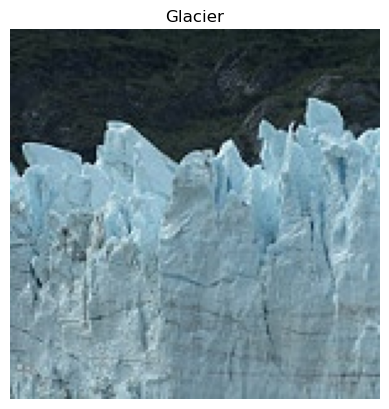

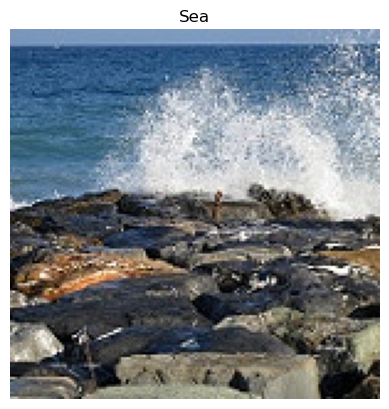


**************************************************



In [7]:
df = pd.read_csv("/kaggle/input/iic-dataframe/test.csv")

breaker()
for model_name in sorted(os.listdir("onnx")):
    
    onnx_model = OnnxModel(f"onnx/{model_name}")
    
    print(f"{model_name.upper()}\n")
    
    for i in range(9):
        index = r.randint(0, len(df)-1)
        filepath = df.iloc[index, 0]
        # y_true   = df.iloc[index, 1]

        image = get_image(filepath)

        y_pred, _ = onnx_model.infer(image, labels)
        
        # print(f"{labels[str(y_true)].title()}, {y_pred}")
        show_image(image, title=y_pred)

    breaker()